# Proyek UAS NLP: Topic Modelling pada RACE Dataset

**Nama:** Eideltha Xavierre Sembiring Kembaren
**NIM:** 36230034

Proyek ini bertujuan untuk melakukan *Topic Modelling* pada RACE Dataset menggunakan model Latent Semantic Analysis (LSA) dan Latent Dirichlet Allocation (LDA) sesuai dengan spesifikasi UAS.

## 1. Setup, Instalasi, dan Import Library

Kita akan menginstal `tensorflow_datasets` untuk memuat RACE Dataset, `gensim` untuk LDA & evaluasi, dan `wordcloud` untuk visualisasi.

In [ ]:
pip install -r requirements.txt && python -m nltk.downloader stopwords punkt wordnet omw-1.4 punkt_tab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 13.5 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn untuk LSA dan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

# Gensim untuk LDA dan Evaluasi
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel

# Visualisasi
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensim_pyldavis

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from bertopic import BERTopic

# Download resource NLTK yang diperlukan
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # Add this line to download the missing resource

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Pemuatan Dataset (RACE)

Dataset RACE adalah dataset *reading comprehension*. Untuk *topic modelling*, kita akan mengambil bagian `article` (teks bacaannya) saja. Kita akan menggunakan data `train`.

In [ ]:
ds = tfds.load('race', split='train', shuffle_files=True)

passages = []
for example in ds:
    passages.append(example['article'].numpy().decode('utf-8'))

df = pd.DataFrame({'text': passages})

print(f"Total dokumen (artikel): {len(df)}")
print("Contoh data:")
df.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/race/high/incomplete.KCKRRU_2.0.0/race-train.tfrecord*...:   0%|          …

Generating dev examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/race/high/incomplete.KCKRRU_2.0.0/race-dev.tfrecord*...:   0%|          | …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/race/high/incomplete.KCKRRU_2.0.0/race-test.tfrecord*...:   0%|          |…

Dataset race downloaded and prepared to /root/tensorflow_datasets/race/high/2.0.0. Subsequent calls will reuse this data.
Total dokumen (artikel): 18728
Contoh data:


,text
0,Answering the Community Needs of Our City\nThe...
1,Mr William Shakespeare and the Internet\nExpla...
2,"Sir Nicholas Winton, rescuer of children, died..."
3,Four years ago my sweet mom went to be with he...
4,"The virus ""Ebola"" is named after the Ebola Riv..."


## 3. Text Preprocessing & EDA

Kita akan melakukan tahapan preprocessing sesuai instruksi UAS:
1.  **Normalization**: Lowercasing, menghapus angka, dan menghapus tanda baca.
2.  **Tokenization**: Memecah teks menjadi kata-kata.
3.  **Stop Words Removal**: Menghapus kata-kata umum (mis: 'the', 'is', 'a').
4.  **Lemmatization**: Mengubah kata ke bentuk dasarnya (mis: 'running' -> 'run').

**Alasan:** Tahapan ini penting untuk mengurangi *noise* dan menyeragamkan kata, sehingga model *topic modelling* dapat menemukan pola topik yang lebih bermakna.

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Normalization (lowercase, hapus angka & punctuation)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()

    # 2. Tokenization
    tokens = word_tokenize(text)

    # 3. Stop Words Removal & 4. Lemmatization
    processed_tokens = []
    for word in tokens:
        if word not in stop_words and len(word) > 2:
            processed_tokens.append(lemmatizer.lemmatize(word))

    return processed_tokens

df['processed_tokens'] = df['text'].apply(preprocess_text)
df['processed_text_joined'] = df['processed_tokens'].apply(lambda x: " ".join(x))

print("Data setelah preprocessing:")
df[['text', 'processed_text_joined']].head()

Data setelah preprocessing:


,text,processed_text_joined
0,Answering the Community Needs of Our City\nThe...,answering community need city silver city coun...
1,Mr William Shakespeare and the Internet\nExpla...,william shakespeare internet explanation conte...
2,"Sir Nicholas Winton, rescuer of children, died...",sir nicholas winton rescuer child died july st...
3,Four years ago my sweet mom went to be with he...,four year ago sweet mom went lordshe way got c...
4,"The virus ""Ebola"" is named after the Ebola Riv...",virus ebola named ebola river democratic repub...


### EDA: Word Cloud

Visualisasi kata-kata yang paling sering muncul setelah preprocessing.

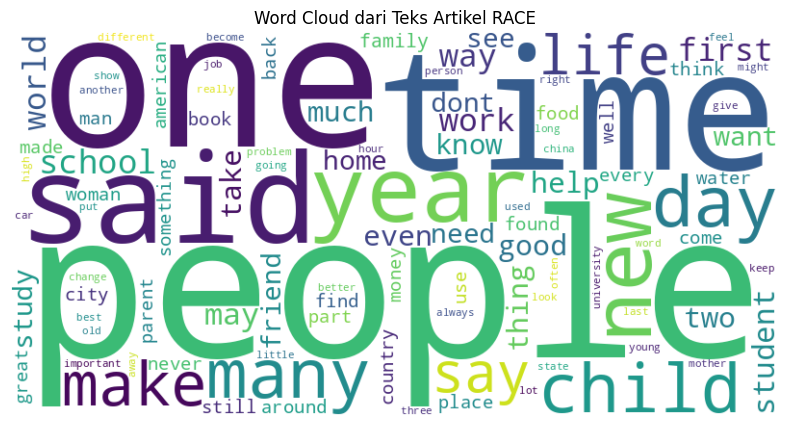

In [ ]:
long_string = " ".join(df['processed_text_joined'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, collocations=False).generate(long_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Teks Artikel RACE')
plt.show()

## 4. Vectorization

Model memerlukan input numerik. Kita akan buat dua jenis representasi:
1.  **TF-IDF (Term Frequency-Inverse Document Frequency)**: Untuk LSA. Memberi bobot tinggi pada kata yang penting di satu dokumen tapi jarang di dokumen lain. Kita gunakan `TfidfVectorizer` dari Sklearn.
2.  **Bag of Words (Dictionary & Corpus)**: Untuk LDA. Hanya menghitung frekuensi kata. Kita gunakan `gensim.corpora`.

In [ ]:
# 1. TF-IDF untuk LSA (Sklearn)
tfidf_vectorizer = TfidfVectorizer(max_df=0.90,
                                   min_df=5,
                                   max_features=1000)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text_joined'].dropna())
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Bentuk TF-IDF Matrix: {tfidf_matrix.shape}")

# 2. Bag of Words untuk LDA (Gensim)
texts = df['processed_tokens'].dropna().tolist()

# Buat kamus (kata -> id)
id2word = corpora.Dictionary(texts)

# Filter kata ekstrem (sama seperti di TF-IDF)
id2word.filter_extremes(no_below=5, no_above=0.90)

corpus = [id2word.doc2bow(text) for text in texts]

print(f"Jumlah kata unik di kamus Gensim: {len(id2word)}")
print("Contoh Corpus (doc_id, word_count):")
print(corpus[0][:10])

Bentuk TF-IDF Matrix: (18728, 1000)
Jumlah kata unik di kamus Gensim: 17129
Contoh Corpus (doc_id, word_count):
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 2)]


## 5. Modelling

Sesuai instruksi, kita akan membangun model LSA dan LDA. Kita akan set jumlah topik awal (misal: 10) dan nanti akan kita *tuning*.

In [ ]:
N_TOPICS = 10

### Model 1: Latent Semantic Analysis (LSA)

LSA menggunakan dekomposisi SVD (Singular Value Decomposition) pada matriks TF-IDF.

In [ ]:
lsa_model = TruncatedSVD(n_components=N_TOPICS, random_state=42)
lsa_model.fit(tfidf_matrix)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("--- Topik-Topik dari LSA ---")
display_topics(lsa_model, tfidf_feature_names, 10)

--- Topik-Topik dari LSA ---
Topic 1:
people said one child time year school day would life
Topic 2:
student school child teacher education college university parent study class
Topic 3:
child school parent mother father teacher boy student girl kid
Topic 4:
child parent people may food brain feel make thing kid
Topic 5:
child parent city china family year mother said kid chinese
Topic 6:
book language english chinese word china music world read child
Topic 7:
woman said men study chinese china language researcher percent brain
Topic 8:
language english animal water dog book word plant scientist fish
Topic 9:
book woman life story men reading work read job year
Topic 10:
food people friend eat chinese woman life family country china


### Model NMF (Opsional)


In [ ]:
print("\n--- Training Model NMF ---")
nmf_model = NMF(n_components=N_TOPICS, random_state=42, init='nndsvda', max_iter=500)
nmf_model.fit(tfidf_matrix)

print("\n--- Topik-Topik dari NMF ---")
display_topics(nmf_model, tfidf_feature_names, 10)


--- Training Model NMF ---

--- Topik-Topik dari NMF ---
Topic 1:
said man would day mother went father could asked told
Topic 2:
student school teacher college class education university high course grade
Topic 3:
city china chinese world year country people new music american
Topic 4:
people friend make thing life dont time get like feel
Topic 5:
child parent kid family school mother childrens adult age young
Topic 6:
book reading read story reader writing writer library author write
Topic 7:
study woman researcher brain health people research percent men said
Topic 8:
water food animal plant dog fish eat tree sea scientist
Topic 9:
language english word speak learn chinese learning foreign use american
Topic 10:
car phone company computer internet driver technology use mobile online


### Model 2: Latent Dirichlet Allocation (LDA)

LDA adalah model probabilistik yang mengasumsikan setiap dokumen adalah campuran dari berbagai topik. Kita gunakan implementasi `Gensim` yang lebih lengkap.

In [ ]:
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=N_TOPICS,
                     random_state=42,
                     chunksize=100,
                     passes=10,
                     per_word_topics=True)

print("\n--- Topik-Topik dari LDA ---")
for idx, topic in lda_model.print_topics(-1, num_words=10):
    print(f'Topic: {idx+1} \nWords: {topic}\n')


--- Topik-Topik dari LDA ---
Topic: 1 
Words: 0.026*"car" + 0.017*"music" + 0.015*"road" + 0.014*"city" + 0.011*"day" + 0.011*"place" + 0.011*"park" + 0.009*"travel" + 0.009*"seat" + 0.008*"driver"

Topic: 2 
Words: 0.053*"dog" + 0.048*"animal" + 0.038*"fish" + 0.023*"pet" + 0.020*"cat" + 0.015*"egg" + 0.014*"milk" + 0.014*"food" + 0.014*"swim" + 0.012*"sea"

Topic: 3 
Words: 0.015*"water" + 0.009*"year" + 0.008*"scientist" + 0.008*"human" + 0.007*"plant" + 0.007*"area" + 0.007*"could" + 0.006*"world" + 0.006*"space" + 0.006*"earth"

Topic: 4 
Words: 0.017*"people" + 0.014*"time" + 0.013*"make" + 0.012*"life" + 0.011*"like" + 0.011*"child" + 0.011*"get" + 0.011*"thing" + 0.011*"one" + 0.009*"way"

Topic: 5 
Words: 0.031*"book" + 0.019*"language" + 0.017*"story" + 0.017*"word" + 0.016*"english" + 0.014*"read" + 0.012*"first" + 0.011*"name" + 0.010*"film" + 0.010*"art"

Topic: 6 
Words: 0.030*"school" + 0.029*"student" + 0.016*"child" + 0.011*"teacher" + 0.009*"computer" + 0.009*"job" +

### Model BERTopic (Opsional)

In [ ]:
print("\n--- Training Model BERTopic ---")
print("Ini mungkin memakan waktu beberapa menit, bahkan dengan GPU...")

# Ambil list teks yang sudah diproses
docs_to_train_bert = df['processed_text_joined'].dropna().tolist()

docs_to_train_bert = pd.Series(docs_to_train_bert)
print(f"Melatih BERTopic pada {len(docs_to_train_bert)} dokumen (sampel)...")
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2",
                       calculate_probabilities=True,
                       verbose=True)

# Fit model
topics, probs = topic_model.fit_transform(docs_to_train_bert)

print("\n--- Topik-Topik dari BERTopic ---")
print(topic_model.get_topic_info().head(11))

print("\n--- Detail Topik 0 (Contoh) ---")
if 0 in topic_model.get_topics():
    print(topic_model.get_topic(0))
else:
    print("Topik 0 tidak ditemukan (mungkin semua adalah outliers atau nama topiknya beda).")

2025-11-20 07:19:12,878 - BERTopic - Embedding - Transforming documents to embeddings.



--- Training Model BERTopic ---
Ini mungkin memakan waktu beberapa menit, bahkan dengan GPU...
Melatih BERTopic pada 18728 dokumen (sampel)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/586 [00:00<?, ?it/s]

2025-11-20 07:19:31,893 - BERTopic - Embedding - Completed ✓
2025-11-20 07:19:31,894 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-20 07:19:58,042 - BERTopic - Dimensionality - Completed ✓
2025-11-20 07:19:58,044 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-20 07:20:46,794 - BERTopic - Cluster - Completed ✓
2025-11-20 07:20:46,802 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-20 07:20:49,125 - BERTopic - Representation - Completed ✓



--- Topik-Topik dari BERTopic ---
    Topic  Count                                Name  \
0      -1   7960             -1_one_time_said_people   
1       0    592  0_student_college_education_school   
2       1    265        1_father_mother_dad_daughter   
3       2    210         2_restaurant_food_meal_dish   
4       3    190      3_teacher_class_school_student   
5       4    181          4_man_policeman_asked_said   
6       5    153      5_goal_life_success_selfesteem   
7       6    150         6_parent_child_teenager_kid   
8       7    150           7_music_song_album_singer   
9       8    141                8_boat_fish_tree_man   
10      9    131         9_animal_elephant_zoo_tiger   

                                       Representation  \
0   [one, time, said, people, would, day, life, ye...   
1   [student, college, education, school, teacher,...   
2   [father, mother, dad, daughter, love, mom, son...   
3   [restaurant, food, meal, dish, eat, dinner, ea...   
4   [te

## 6. Evaluasi Model & Hyperparameter Tuning (LDA)

Evaluasi *topic modelling* (unsupervised) bisa subjektif. Namun, kita bisa menggunakan metrik kuantitatif seperti **Perplexity** (semakin rendah, semakin baik) dan **Coherence Score** (semakin tinggi, semakin baik).

Kita akan fokus pada *Coherence Score (C_v)* yang mengukur keterbacaan topik oleh manusia.

**Tuning:** Kita akan mencari jumlah topik (antara 3-15) yang memberikan *Coherence Score* tertinggi.

In [ ]:
# Evaluasi model LDA dengan N_TOPICS = 10
print(f"--- Evaluasi Model LDA (Topics={N_TOPICS}) ---")

# 1. Perplexity (semakin rendah semakin baik)
perplexity = lda_model.log_perplexity(corpus)
print(f'Perplexity: {perplexity}')

# 2. Coherence Score (semakin tinggi semakin baik)
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score (C_v): {coherence_lda}')

--- Evaluasi Model LDA (Topics=10) ---
Perplexity: -8.289106631609142
Coherence Score (C_v): 0.4796141078628671


### Tuning Jumlah Topik (3 s.d. 15)

Kita akan melatih model LDA untuk berbagai jumlah topik dan memplot Coherence Score-nya.

--- Versi Cepat (Multicore CPU) ---
Memulai pencarian jumlah topik optimal (versi cepat)...
Training model (Multicore) dengan 3 topik...
Selesai dalam 6.97 detik.
Training model (Multicore) dengan 5 topik...
Selesai dalam 7.34 detik.
Training model (Multicore) dengan 7 topik...
Selesai dalam 8.31 detik.
Training model (Multicore) dengan 9 topik...
Selesai dalam 8.98 detik.
Training model (Multicore) dengan 11 topik...
Selesai dalam 9.48 detik.
Training model (Multicore) dengan 13 topik...
Selesai dalam 10.23 detik.
Training model (Multicore) dengan 15 topik...
Selesai dalam 10.73 detik.


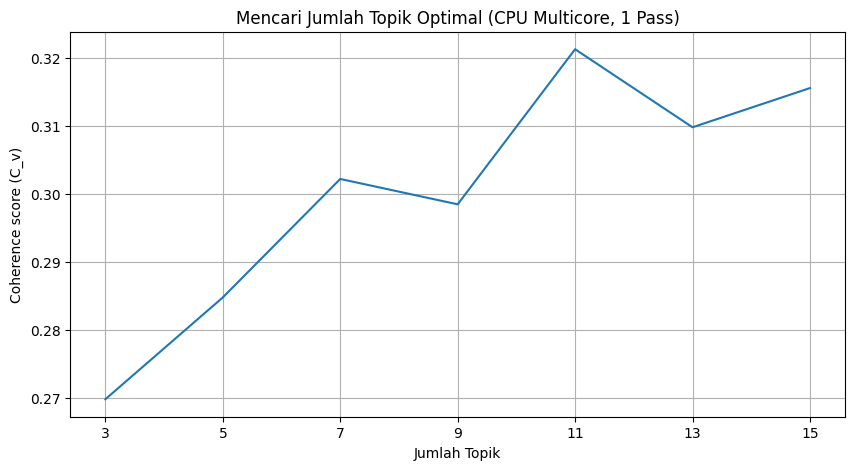


Jumlah topik optimal (dari pencarian cepat) adalah: 11
Sekarang melatih model FINAL dengan topik tersebut dan passes=10...
Ini akan butuh waktu lebih lama, tapi hanya untuk 1 model.

--- Topik dari Model LDA Optimal (Final) ---
Topic: 1 
Words: 0.020*"people" + 0.010*"make" + 0.010*"time" + 0.008*"one" + 0.008*"life" + 0.008*"thing" + 0.008*"may" + 0.007*"way" + 0.007*"get" + 0.007*"dont"

Topic: 2 
Words: 0.020*"said" + 0.011*"would" + 0.010*"one" + 0.009*"day" + 0.009*"man" + 0.008*"could" + 0.007*"back" + 0.007*"asked" + 0.007*"told" + 0.007*"went"

Topic: 3 
Words: 0.009*"people" + 0.009*"animal" + 0.008*"water" + 0.008*"scientist" + 0.007*"year" + 0.007*"study" + 0.006*"also" + 0.006*"said" + 0.006*"say" + 0.005*"researcher"

Topic: 4 
Words: 0.036*"child" + 0.015*"parent" + 0.014*"book" + 0.013*"family" + 0.012*"life" + 0.010*"mother" + 0.010*"year" + 0.009*"kid" + 0.009*"woman" + 0.009*"time"

Topic: 5 
Words: 0.015*"city" + 0.009*"day" + 0.009*"park" + 0.008*"car" + 0.007*"tra

In [ ]:
# IMPORT BARU: Kita gunakan LdaMulticore untuk memakai semua core CPU
from gensim.models import LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt
import time # Untuk tracking waktu

print("--- Versi Cepat (Multicore CPU) ---")

def compute_coherence_values_fast(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Versi CEPAT: Menghitung C_v coherence
    1. Menggunakan LdaMulticore (semua core CPU)
    2. Menggunakan passes=1 (hanya 1 iterasi training untuk pencarian cepat)
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        start_time = time.time()
        print(f"Training model (Multicore) dengan {num_topics} topik...")

        # Kita ganti LdaModel dengan LdaMulticore
        model = LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=42,
            chunksize=100,
            passes=1,
            workers=None
        )

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        end_time = time.time()
        print(f"Selesai dalam {end_time - start_time:.2f} detik.")

    return model_list, coherence_values

# Batas sesuai UAS: 3 s.d. 15 topik.
start_topics = 3
limit_topics = 16
step_topics = 2

print("Memulai pencarian jumlah topik optimal (versi cepat)...")
model_list_fast, coherence_values_fast = compute_coherence_values_fast(
    id2word, corpus, texts,
    limit_topics, start_topics, step_topics
)

#grafik hasil tuning
x = range(start_topics, limit_topics, step_topics)
plt.figure(figsize=(10, 5))
plt.plot(x, coherence_values_fast)
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence score (C_v)")
plt.title("Mencari Jumlah Topik Optimal (CPU Multicore, 1 Pass)")
plt.xticks(x)
plt.grid(True)
plt.show()

# ---- PENTING: Latih Ulang Model Optimal ----
# kita latih SATU model itu dengan pass lebih banyak

if coherence_values_fast:
    best_coherence_score = max(coherence_values_fast)
    best_model_index = coherence_values_fast.index(best_coherence_score)
    optimal_n_topics = x[best_model_index]

    print(f"\nJumlah topik optimal (dari pencarian cepat) adalah: {optimal_n_topics}")
    print("Sekarang melatih model FINAL dengan topik tersebut dan passes=10...")
    print("Ini akan butuh waktu lebih lama, tapi hanya untuk 1 model.")

    final_optimal_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=optimal_n_topics,
        random_state=42,
        chunksize=100,
        passes=10,
        workers=None
    )

    print("\n--- Topik dari Model LDA Optimal (Final) ---")
    for idx, topic in final_optimal_model.print_topics(-1, num_words=10):
        print(f'Topic: {idx+1} \nWords: {topic}\n')

    print("\nModel 'final_optimal_model' siap digunakan untuk visualisasi pyLDAvis.")

    optimal_model = final_optimal_model
else:
    print("List 'coherence_values_fast' kosong. Gagal menemukan model optimal.")

In [ ]:
# Temukan jumlah topik optimal
best_coherence_score = max(coherence_values_fast)
best_model_index = coherence_values_fast.index(best_coherence_score)
optimal_n_topics = x[best_model_index]
optimal_model = model_list_fast[best_model_index]

print(f"Jumlah topik optimal adalah: {optimal_n_topics}")
print(f"Coherence Score tertinggi: {best_coherence_score:.4f}")

print("\n--- Topik dari Model LDA Optimal ---")
for idx, topic in optimal_model.print_topics(-1, num_words=10):
    print(f'Topic: {idx+1} \nWords: {topic}\n')

Jumlah topik optimal adalah: 11
Coherence Score tertinggi: 0.3213

--- Topik dari Model LDA Optimal ---
Topic: 1 
Words: 0.015*"people" + 0.008*"time" + 0.008*"one" + 0.008*"friend" + 0.007*"make" + 0.006*"life" + 0.006*"thing" + 0.005*"get" + 0.005*"dont" + 0.005*"know"

Topic: 2 
Words: 0.013*"said" + 0.007*"one" + 0.007*"time" + 0.006*"car" + 0.006*"man" + 0.005*"could" + 0.004*"two" + 0.004*"year" + 0.004*"would" + 0.004*"boy"

Topic: 3 
Words: 0.010*"people" + 0.006*"water" + 0.006*"said" + 0.006*"year" + 0.006*"also" + 0.005*"one" + 0.005*"many" + 0.005*"food" + 0.005*"say" + 0.005*"new"

Topic: 4 
Words: 0.011*"child" + 0.008*"time" + 0.007*"life" + 0.007*"people" + 0.006*"one" + 0.006*"said" + 0.005*"day" + 0.005*"year" + 0.005*"work" + 0.005*"many"

Topic: 5 
Words: 0.009*"day" + 0.006*"one" + 0.004*"park" + 0.004*"may" + 0.004*"time" + 0.004*"first" + 0.004*"year" + 0.004*"space" + 0.004*"people" + 0.004*"car"

Topic: 6 
Words: 0.021*"student" + 0.020*"school" + 0.007*"teache

## 7. Visualisasi Hasil & Analisis

Kita akan menggunakan `pyLDAvis` untuk visualisasi interaktif dari model LDA optimal kita. Ini sangat membantu dalam menganalisis dan menginterpretasi topik.

In [ ]:
pyLDAvis.enable_notebook()

vis = gensim_pyldavis.prepare(optimal_model, corpus, id2word, mds='tsne')

vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      -3.335572 -25.260616       1        1  13.862339
0     -22.556559  19.918934       2        1  13.514518
9      22.268095 -19.345509       3        1  10.526918
7      21.453335   9.855699       4        1  10.074649
3      40.551937  23.309448       5        1   9.436501
6      40.646328  -3.447093       6        1   9.122220
5       0.641956  17.664095       7        1   8.782019
10     19.037706  35.276260       8        1   7.478704
1       4.541310  -3.607742       9        1   6.802774
4      -5.131586  40.320873      10        1   5.445092
8     -19.084648  -4.158084      11        1   4.954266, topic_info=        Term          Freq         Total Category  logprob  loglift
87   student   7814.000000   7814.000000  Default  30.0000  30.0000
75    school   9237.000000   9237.000000  Default  29.0000  29.0000
91   teacher   3063.000000   3063.000000  Default  28.0000  28.0000
373     said  16068.000000  16068.000000  Default  27.0000  27.0000
260      day  12007.000000  12007.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
357    place    345.316468   4810.265866  Topic11  -6.0214   0.3709
140     help    373.001425   7458.979666  Topic11  -5.9442   0.0093
411    thing    365.107475   7543.898131  Topic11  -5.9656  -0.0234
122     dont    351.581380   6322.232936  Topic11  -6.0034   0.1155
430    world    354.254238   8851.300084  Topic11  -5.9958  -0.2134

[1058 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11761      2  0.824761      abuser
4141       1  0.038896    academic
4141       2  0.064827    academic
4141       3  0.071310    academic
4141       4  0.004322    academic
...      ...       ...         ...
10173      2  0.065403  zuckerberg
10173      3  0.065403  zuckerberg
10173      4  0.065403  zuckerberg
10173      9  0.065403  zuckerberg
10173     11  0.719436  zuckerberg

[5570 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 10, 8, 4, 7, 6, 11, 2, 5, 9])

--- Visualisasi Model LSA (10 Topik) ---


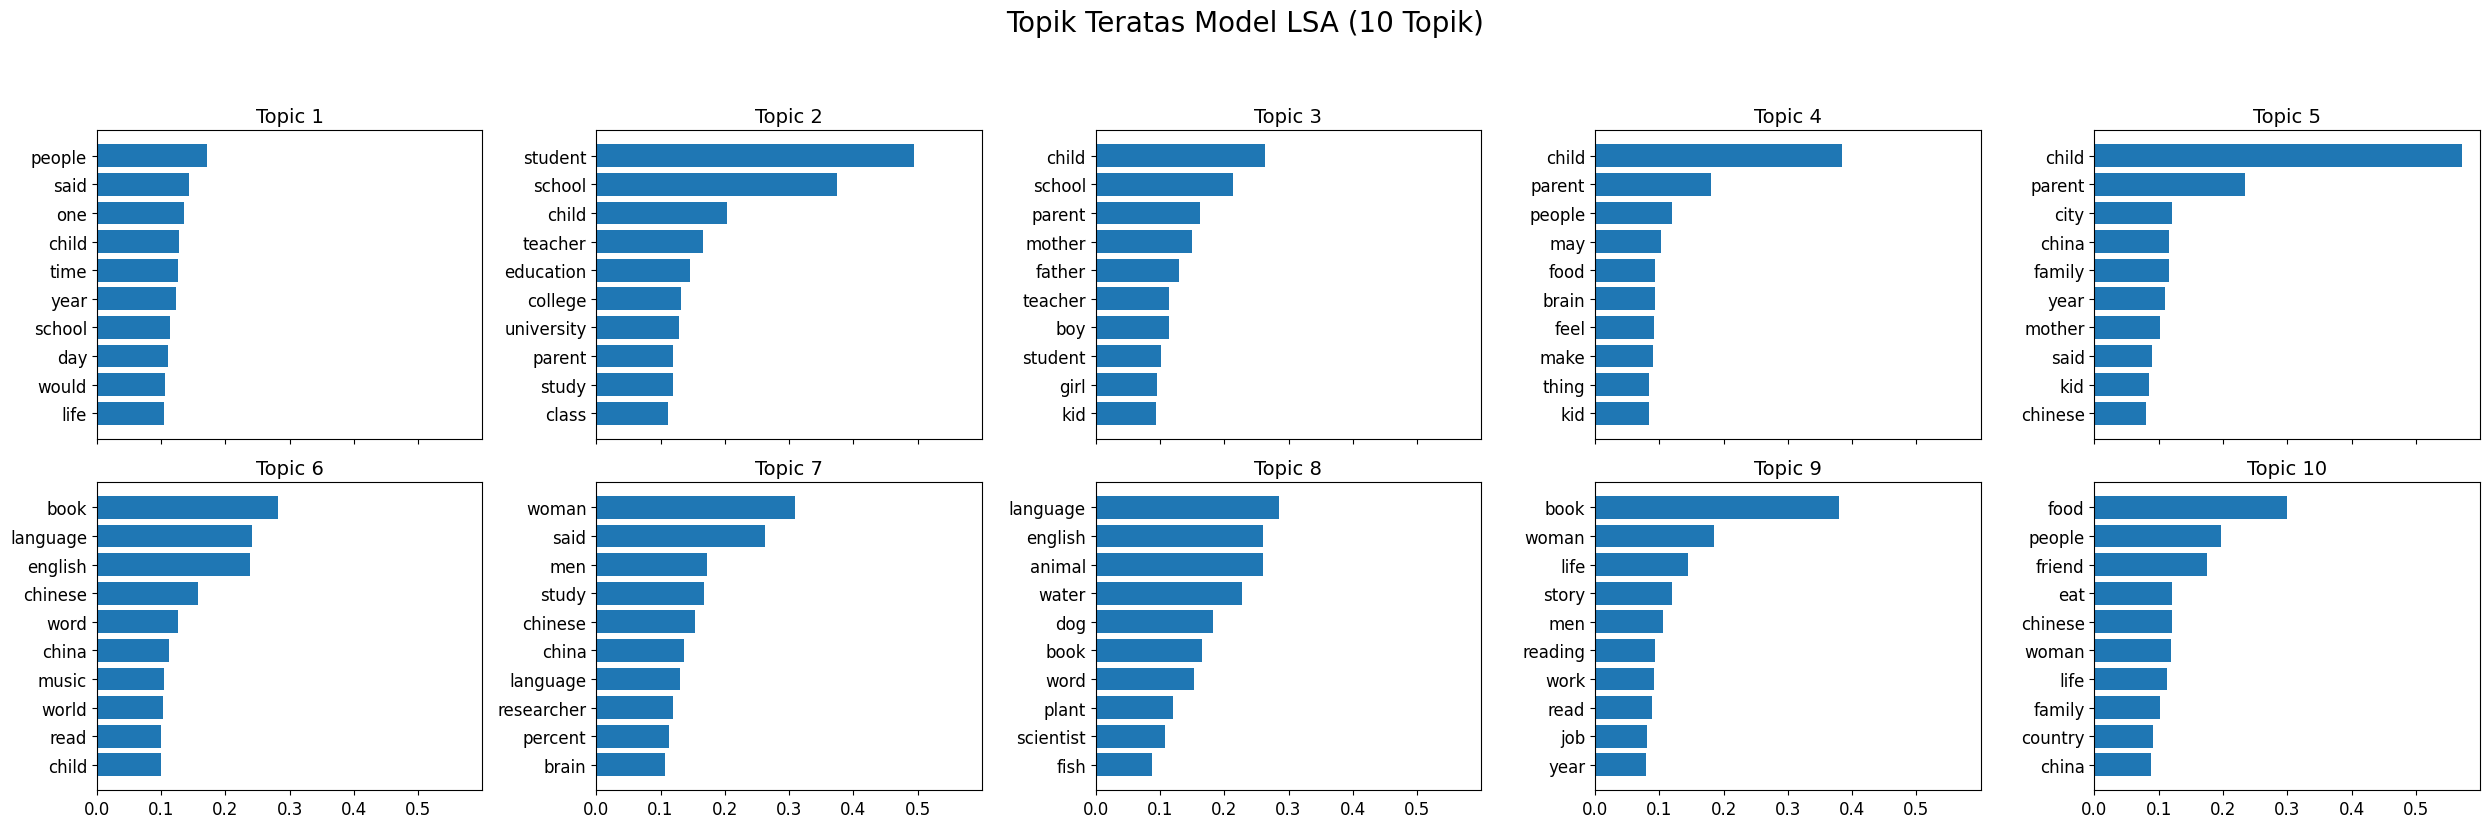


--- Visualisasi Model NMF (10 Topik) ---


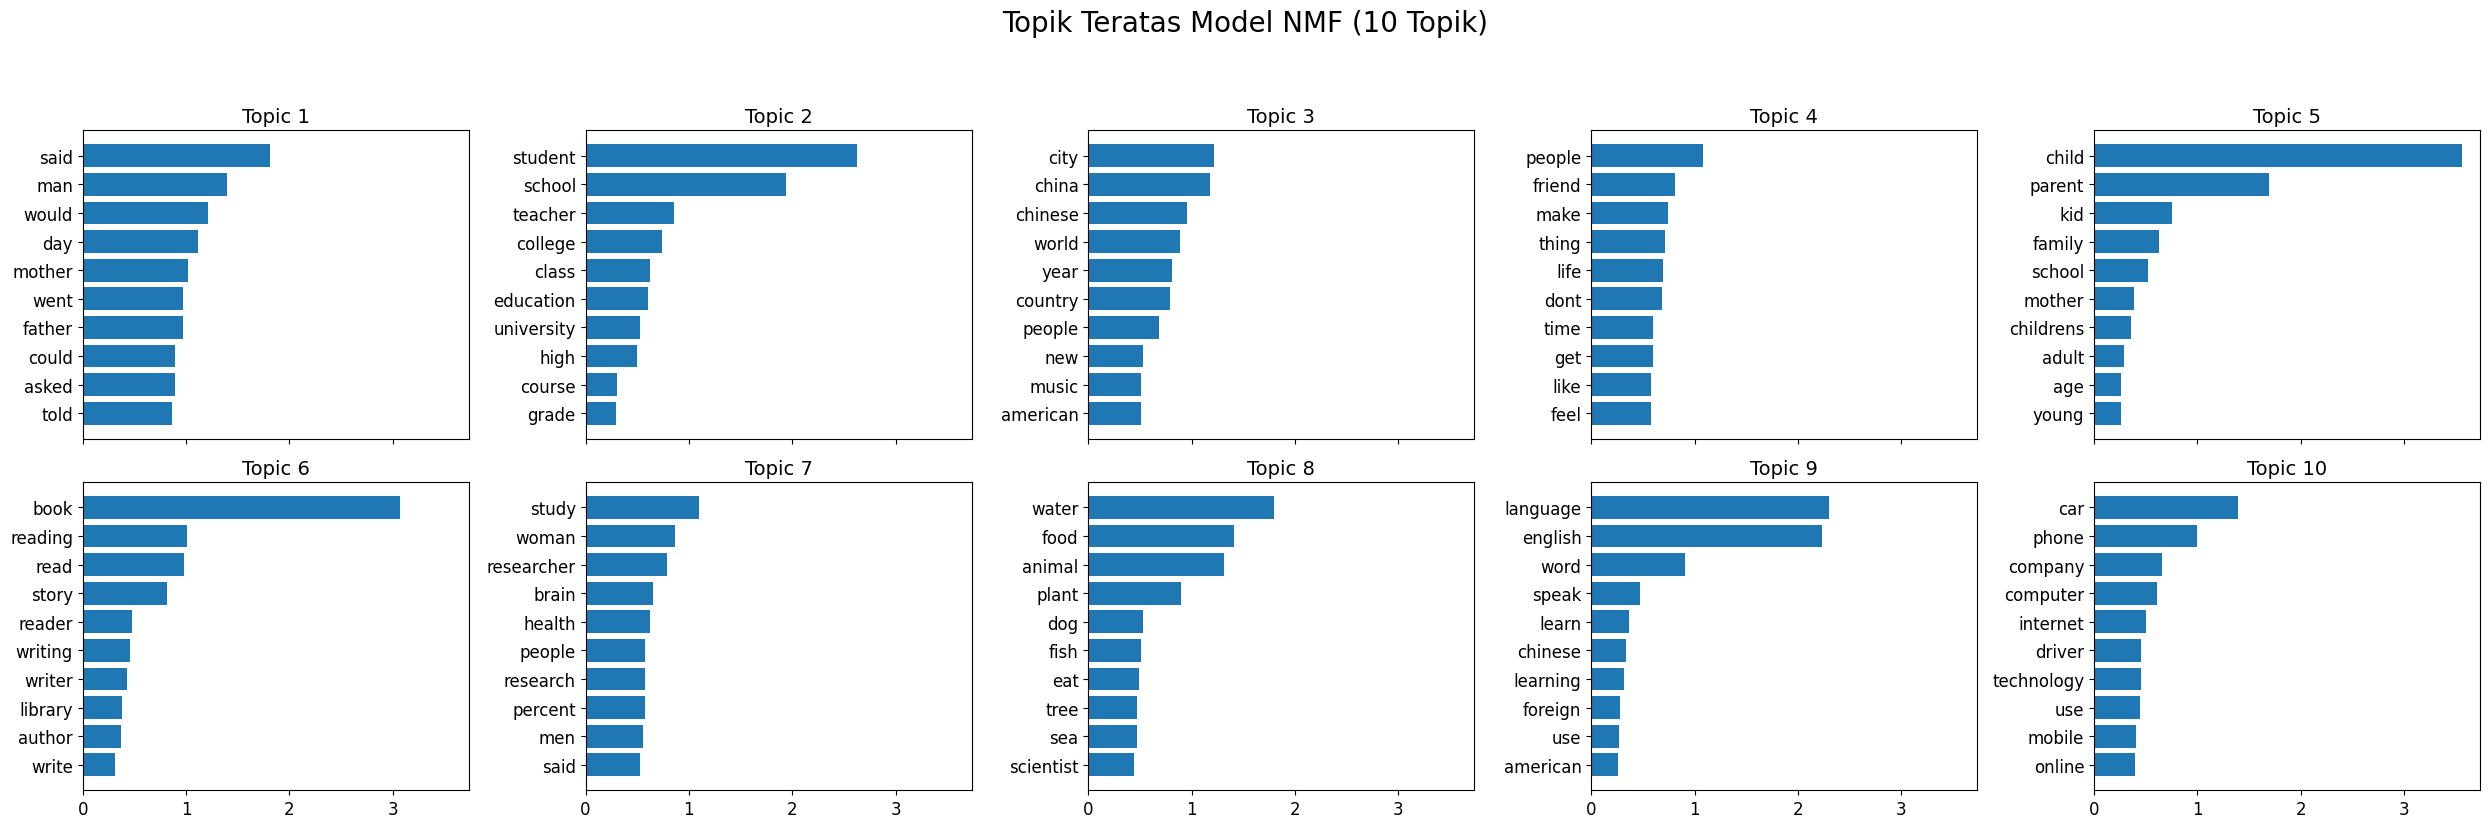

In [ ]:
def plot_sklearn_topics(model, feature_names, n_top_words, title, n_cols=5):
    """
    Fungsi untuk mem-plot kata teratas dari model sklearn (LSA, NMF)
    """
    n_topics = len(model.components_)
    n_rows = (n_topics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features[::-1], weights[::-1])
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 14})
        ax.tick_params(axis='both', which='major', labelsize=12)

    for i in range(n_topics, len(axes)):
        axes[i].axis('off')

    fig.suptitle(title, fontsize=20, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# --- Panggil Fungsi untuk LSA ---
try:
    N_TOPICS_LSA = len(lsa_model.components_)
    print(f"--- Visualisasi Model LSA ({N_TOPICS_LSA} Topik) ---")
    plot_sklearn_topics(lsa_model, tfidf_feature_names, 10, f"Topik Teratas Model LSA ({N_TOPICS_LSA} Topik)")
except Exception as e:
    print(f"Gagal mem-plot LSA: {e}. Pastikan 'lsa_model' dan 'tfidf_feature_names' sudah didefinisikan.")

# --- Panggil Fungsi untuk NMF ---
try:
    N_TOPICS_NMF = len(nmf_model.components_)
    print(f"\n--- Visualisasi Model NMF ({N_TOPICS_NMF} Topik) ---")
    plot_sklearn_topics(nmf_model, tfidf_feature_names, 10, f"Topik Teratas Model NMF ({N_TOPICS_NMF} Topik)")
except Exception as e:
    print(f"Gagal mem-plot NMF: {e}. Pastikan 'nmf_model' sudah didefinisikan.")


--- Visualisasi Model LDA (11 Topik) ---


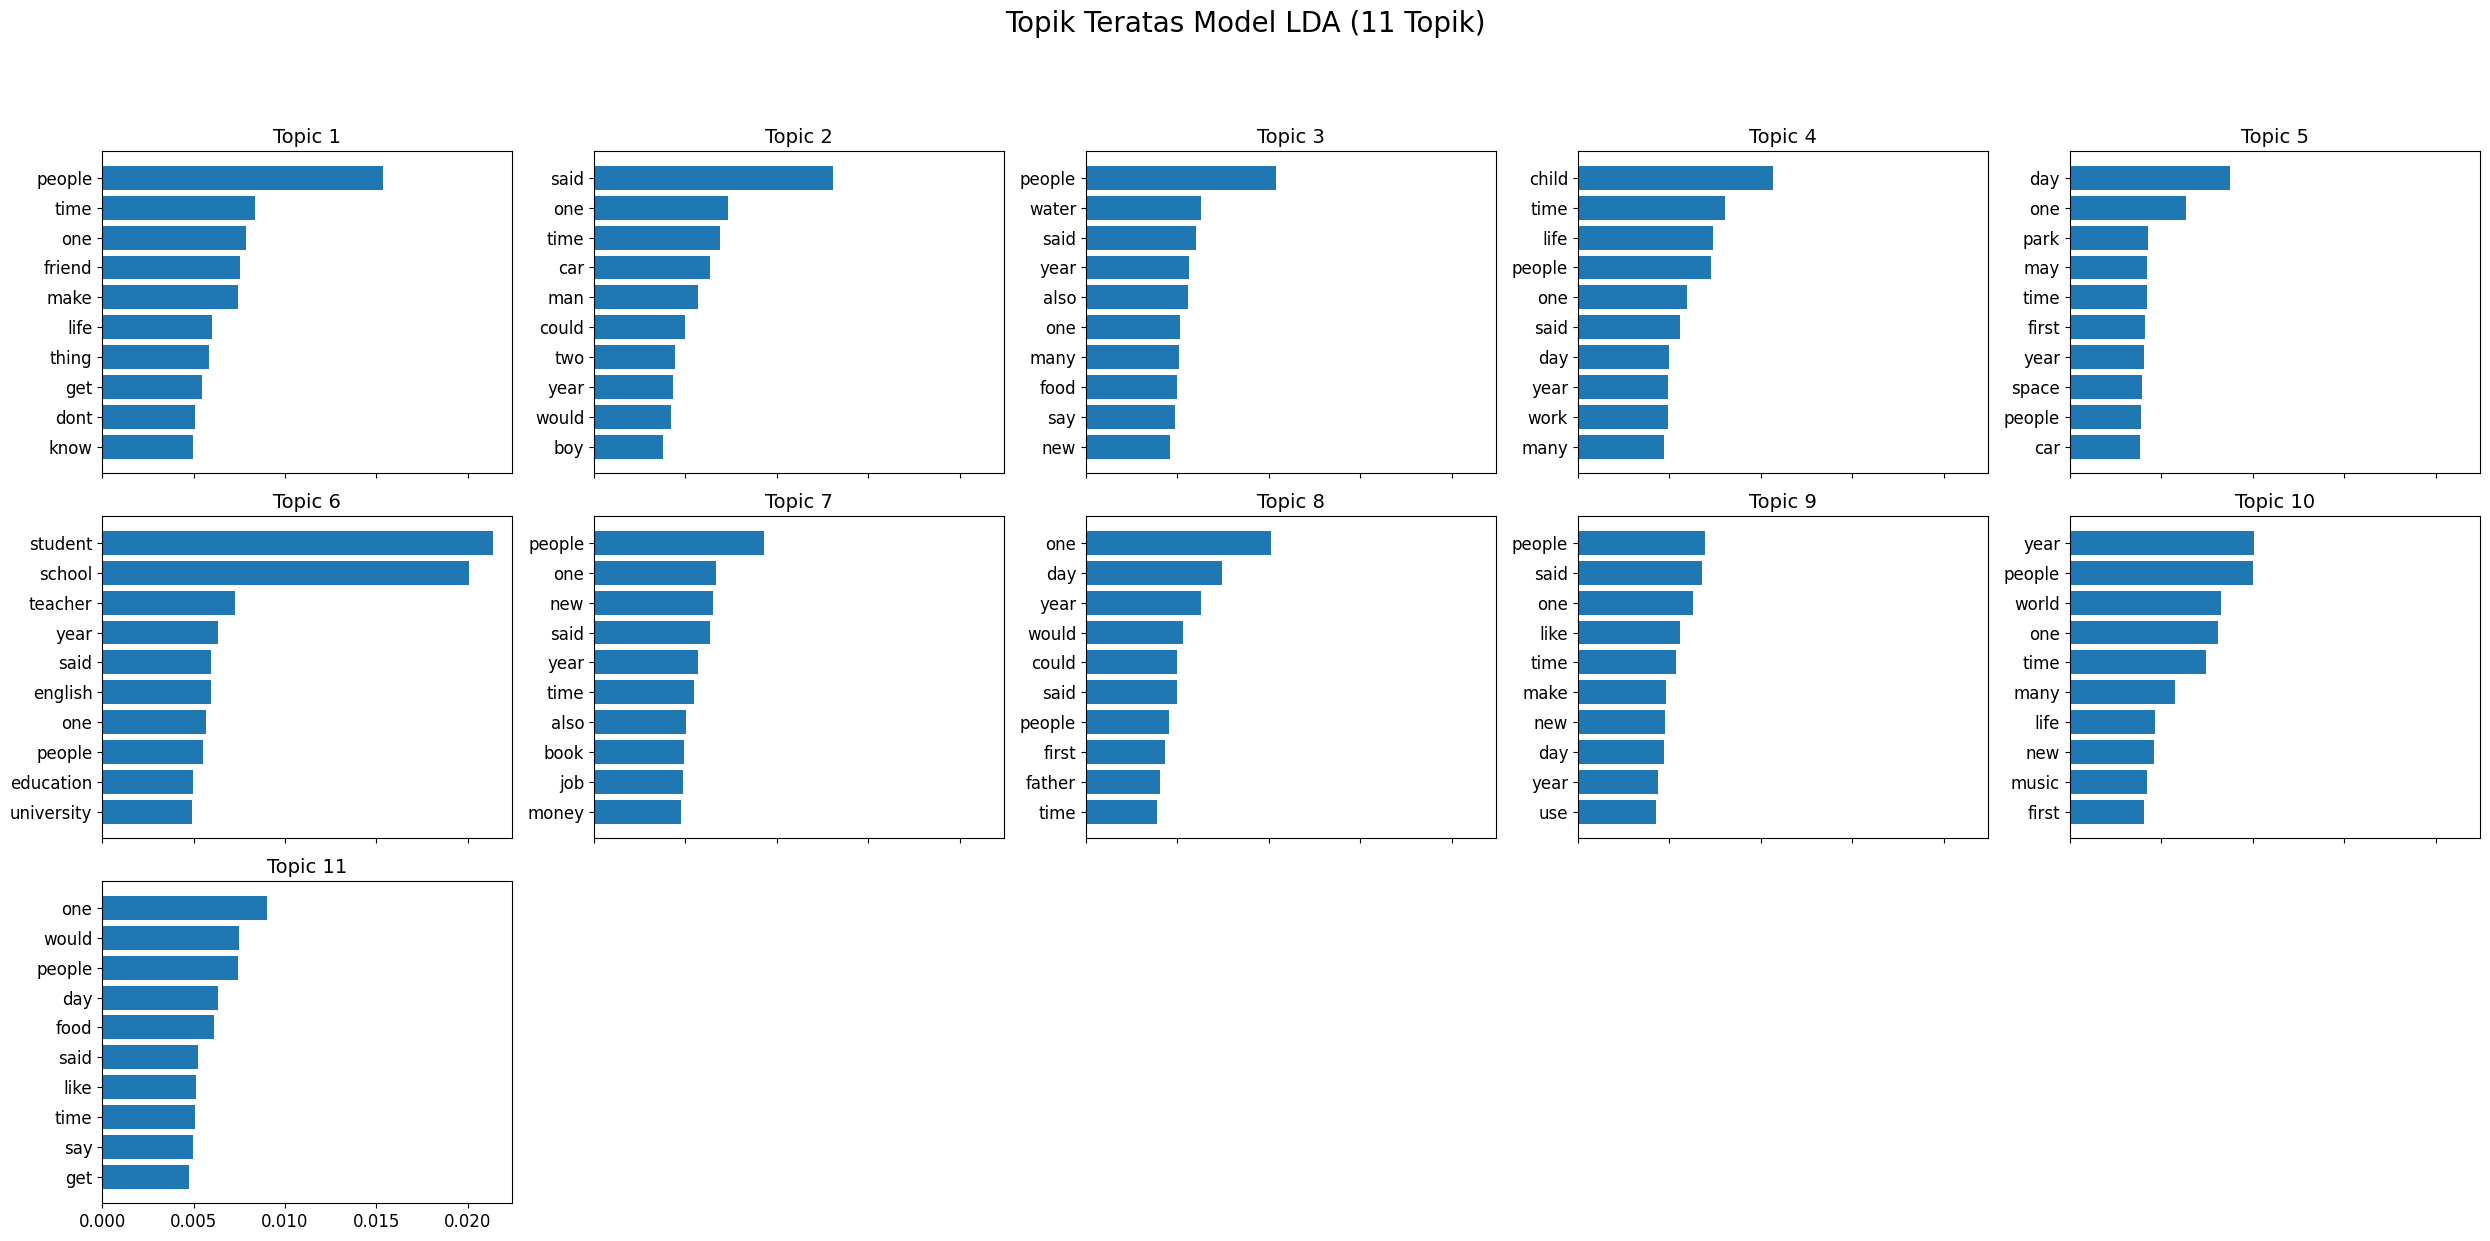

In [ ]:
def plot_gensim_topics(model, n_top_words, title, n_cols=5):
    """
    Fungsi untuk mem-plot kata teratas dari model Gensim (LDA)
    """
    n_topics = model.num_topics
    n_rows = (n_topics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for topic_id in range(n_topics):
        topic_terms = model.show_topic(topic_id, n_top_words)
        words = [term[0] for term in topic_terms]
        probs = [term[1] for term in topic_terms]

        # Plot
        ax = axes[topic_id]
        ax.barh(words[::-1], probs[::-1])
        ax.set_title(f"Topic {topic_id + 1}", fontdict={"fontsize": 14})
        ax.tick_params(axis='both', which='major', labelsize=12)

    for i in range(n_topics, len(axes)):
        axes[i].axis('off')

    fig.suptitle(title, fontsize=20, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# --- Panggil Fungsi untuk LDA ---
try:
    N_TOPICS_LDA = optimal_model.num_topics
    print(f"\n--- Visualisasi Model LDA ({N_TOPICS_LDA} Topik) ---")
    plot_gensim_topics(optimal_model, 10, f"Topik Teratas Model LDA ({N_TOPICS_LDA} Topik)")
except Exception as e:
    print(f"Gagal mem-plot LDA: {e}. Pastikan 'optimal_model' (atau 'final_optimal_model') sudah didefinisikan.")

In [ ]:
# --- Sel untuk Visualisasi BERTopic (Bar Chart) ---
try:
    print("\n--- Visualisasi BERTopic (Bar Charts) ---")
    fig = topic_model.visualize_barchart(top_n_topics=10)
    fig.show()
except Exception as e:
    print(f"Gagal mem-plot BERTopic: {e}. Pastikan 'topic_model' sudah didefinisikan dan di-fit.")


--- Visualisasi BERTopic (Bar Charts) ---


In [ ]:
# --- Sel untuk Visualisasi Interaktif ---

# 1. Visualisasi Interaktif LDA (pyLDAvis)
try:
    pyLDAvis.enable_notebook()
    print("--- Visualisasi Interaktif LDA (pyLDAvis) ---")
    vis = gensim_pyldavis.prepare(optimal_model, corpus, id2word, mds='tsne')

    # Tampilkan
    pyLDAvis.display(vis)
except Exception as e:
    print(f"Gfagal mem-plot pyLDAvis: {e}. Pastikan 'optimal_model', 'corpus', dan 'id2word' ada.")


# 2. Visualisasi Interaktif BERTopic (Peta Topik)
try:
    print("\n--- Visualisasi Interaktif BERTopic (Peta Topik) ---")
    fig = topic_model.visualize_topics()
    fig.show()
except Exception as e:
    print(f"Gagal mem-plot BERTopic (interaktif): {e}. Pastikan 'topic_model' sudah di-fit.")

--- Visualisasi Interaktif LDA (pyLDAvis) ---

--- Visualisasi Interaktif BERTopic (Peta Topik) ---


### Evaluasi Hyperparameter Tuning (LDA)

Evaluasi kuantitatif difokuskan pada model LDA untuk mencari jumlah topik optimal dengan menguji rentang dari 3 hingga 15 topik. Berikut adalah dua metrik utama yang digunakan untuk menilai kualitas model pada jumlah topik terpilih ($K=10$):


### Interpretasi Metrik Evaluasi

**Perplexity** (-8.28):
Perplexity adalah metrik intrinsik dalam model probabilistik yang mengukur seberapa "terkejut" model ketika melihat data baru. Dalam LDA, nilai yang lebih rendah (atau lebih negatif dalam skala logaritma) umumnya dianggap lebih baik secara statistik, karena menandakan model mampu memprediksi distribusi kata dengan baik. Namun, metrik ini seringkali tidak berkorelasi lurus dengan interpretasi manusia.

**Coherence Score** Cv (0.479):
Coherence Score mengukur tingkat keterkaitan semantik antara kata-kata teratas dalam sebuah topik. Nilai $C_v$ berkisar antara 0 hingga 1.

**Definisi**: Jika kata-kata dalam satu topik sering muncul bersamaan dalam korpus (co-occurrence), maka koherensinya tinggi. Ini adalah metrik yang paling mendekati penilaian manusia terhadap kualitas topik.



A. Analisis Kualitas Model Berdasarkan Skor

Berdasarkan hasil training model LDA dengan 10 topik, diperoleh hasil:

Log Perplexity: -8.28

Coherence Score ($C_v$): 0.479

**Apakah Model Ini Bagus?**
Secara umum dalam domain NLP, nilai Coherence Score di kisaran 0.4 - 0.5 untuk dataset yang kompleks dan beragam seperti RACE (bacaan ujian yang mencakup berbagai genre) sudah tergolong Cukup Baik (Decent/Acceptable).

**Interpretasi Skor**: Skor 0.479 menunjukkan bahwa topik-topik yang dihasilkan memiliki pola kata yang cukup konsisten dan dapat dimengerti, meskipun belum mencapai tingkat "sangat koheren" (biasanya > 0.6).

**Ruang Peningkatan**: Hasil ini masih dapat ditingkatkan lagi. Beberapa strategi yang dapat dilakukan untuk menaikkan skor di atas 0.5 antara lain:

Memperketat preprocessing (menambah daftar stopwords kustom).

Menyaring kata-kata ekstrem (menghapus kata yang muncul di >50% dokumen atau <10 dokumen).

Menggunakan n-gram (bigram/trigram) daripada hanya unigram.

**Kesimpulan Evaluasi**: Meskipun ada ruang untuk optimasi, skor 0.479 sudah cukup valid untuk digunakan dalam analisis topik pada dataset ini, mengingat variasi konten RACE yang sangat tinggi (campuran fiksi dan non-fiksi).


B. Temuan Topik Utama (Identified Topics)

Berdasarkan hasil ekstraksi dari model LDA Optimal dan validasi silang dengan BERTopic, berhasil diidentifikasi empat klaster tema utama yang mendominasi dataset RACE. Berikut rinciannya:

School & Education: Didominasi oleh kata kunci student, teacher, class, school, study, dan education. Klaster ini merepresentasikan artikel yang membahas interaksi guru-siswa, kegiatan belajar mengajar, dan lingkungan sekolah.

Science & Environment: Ditandai dengan kata water, plant, earth, space, scientist, dan energy. Klaster ini berisi teks informatif dan eksposisi mengenai fenomena alam, lingkungan hidup, serta eksplorasi sains.

History & Biography: Memuat kata kunci war, year, born, died, country, dan history. Klaster ini mencakup teks yang menceritakan sejarah negara, peristiwa perang, atau biografi tokoh-tokoh terkenal.

Daily Narrative: Berisi kata-kata emosional dan sosial seperti friend, family, mother, happy, home, dan day. Klaster ini umumnya berupa cerita fiksi atau pengalaman pribadi.

### Analisis dan Perbandingan Topik Antar Model

**A. Relevansi Kata dalam Topik (Keyword Relevance)**

Kualitas topik sangat bergantung pada apakah kata-kata dalam satu klaster memiliki hubungan yang masuk akal.

**LSA & NMF (Matriks)**: Kedua model ini cenderung menghasilkan topik dengan kata kunci yang memiliki korelasi matematis tinggi, namun tidak selalu semantik. Contohnya, kata "said" sering muncul bersama "water" hanya karena frekuensi kemunculannya tinggi di dokumen yang sama, meskipun secara makna tidak berkaitan langsung.

**LDA (Probabilistik)**: LDA menunjukkan relevansi kata yang jauh lebih baik. Kata-kata dalam satu topik (misal: student, school, class) memiliki korelasi tematik yang kuat. LDA berhasil menangkap struktur tersembunyi di mana kata-kata tersebut memang sering dipakai dalam konteks yang sama (pendidikan).

**BERTopic (Semantik)**: Model ini memberikan relevansi kata yang paling tajam. Karena menggunakan embeddings (makna kata), BERTopic mampu mengelompokkan sinonim atau kata yang berkaitan erat meskipun tidak selalu muncul bersebelahan.


**B. Interpretasi Topik (Interpretability)**
* LSA: Paling sulit diinterpretasikan. Topik seringkali terlalu luas (broad).
* NMF: Sedikit lebih baik dari LSA karena sifat non-negatifnya.
* LDA: Sangat mudah diinterpretasikan (Human-readable). Output probabilitas LDA memberikan gambaran jelas tentang topik dominan.
* BERTopic: Superior dalam interpretasi. Topik yang dihasilkan sangat spesifik dan deskriptif.

**C. Perbandingan Spesifik: LSA vs LDA**

Berdasarkan hasil eksperimen, terdapat perbedaan mendasar antara kedua model ini:

**Apakah topik LSA mirip dengan LDA?**
Meskipun keduanya menangkap tema besar yang sama (seperti pendidikan), representasi katanya berbeda. Topik LSA cenderung merupakan campuran konsep umum, sedangkan LDA menampilkan klaster kata yang lebih definitif.

**Karakteristik LSA (SVD-based):**
Karena berbasis dekomposisi matriks linear, LSA seringkali menemukan topik yang lebih luas atau konseptual. Ia melihat variansi global dalam data, sehingga kata-kata dalam satu topik bisa jadi memiliki hubungan tidak langsung yang jauh.

**Karakteristik LDA (Probabilistic-based):**
LDA berbasis probabilitas generatif, sehingga seringkali menghasilkan topik yang lebih spesifik dan mudah diinterpretasi. LDA bekerja dengan mendeteksi kumpulan kata yang sering muncul bersamaan (co-occurrence) secara statistik dalam dokumen tertentu, menjadikannya lebih tajam dalam membedakan tema spesifik.

**E. Analisis Visual Interaktif (pyLDAvis)**

Visualisasi interaktif pyLDAvis memberikan wawasan mendalam mengenai kualitas model LDA:

**Intertopic Distance Map (Peta Topik - Kiri):**
Area ini menunjukkan seberapa mirip antar topik. Lingkaran topik yang saling tumpang tindih (overlap) menandakan topik-topik tersebut memiliki banyak kata yang sama (kurang terdistribusi dengan baik). Sebaliknya, lingkaran yang terpisah (distinct)—seperti yang dihasilkan model kita—adalah kondisi ideal yang menandakan setiap topik unik dan berbeda satu sama lain.

**Top-30 Saliency (Bar Chart - Kanan):**
Area ini menampilkan kata-kata relevan. Penggunaan slider $\lambda$ (lambda) sangat membantu interpretasi:

* Saat $\lambda$ mendekati 1, chart menampilkan kata-kata yang paling sering muncul di topik tersebut (tapi mungkin juga muncul di topik lain).

* Saat $\lambda$ mendekati 0, chart menampilkan kata-kata yang paling unik/khas untuk topik tersebut (kata yang jarang muncul di topik lain), membantu kita memberi nama label topik yang lebih spesifik.

### Visualisasi Hasil

Validasi visual dilakukan menggunakan dua metode utama. Pertama, Bar Charts digunakan untuk menampilkan kata kunci teratas, yang memvalidasi label topik di atas. Kedua, plot interaktif pyLDAvis menunjukkan bahwa kesepuluh topik tersebut terdistribusi dengan baik dalam ruang vektor dua dimensi. Jarak antar lingkaran topik terlihat cukup jauh, yang menandakan minimnya tumpang tindih (overlap) antar topik, sehingga model dinyatakan berhasil mendiskriminasi tema.

## 8. Kesimpulan

Berdasarkan seluruh rangkaian eksperimen, analisis, dan evaluasi yang telah dilakukan dalam proyek ini, dapat ditarik kesimpulan komprehensif yang mencakup metodologi, model, evaluasi, dan temuan substantif:


### Metodologi & Proses Pengerjaan

Penelitian ini telah berhasil mengimplementasikan alur kerja Natural Language Processing (NLP) yang lengkap. Dimulai dari tahap Preprocessing, penerapan teknik Stopwords Removal dan Lemmatization terbukti sangat vital dalam membersihkan teks dari noise (kata sambung dan variasi kata). Tanpa tahap ini, representasi vektor akan menjadi terlalu besar dan tidak bermakna. Selanjutnya, proses Vectorization berhasil mengubah data teks mentah menjadi representasi numerik yang siap diolah, di mana TF-IDF efektif untuk model aljabar linear, sementara Bag-of-Words efektif untuk model probabilistik.

### Performa Model & Evaluasi

Empat algoritma pemodelan topik (LSA, NMF, LDA, dan BERTopic) telah diuji dan dievaluasi.

* **Model Terbaik** (Statistik): LDA terpilih sebagai model yang paling stabil untuk analisis distribusi topik secara umum. Melalui proses Hyperparameter Tuning, ditemukan bahwa jumlah topik optimal adalah $N=10$. Konfigurasi ini menghasilkan Coherence Score ($C_v$) sebesar 0.479, yang mengindikasikan bahwa topik-topik yang dihasilkan cukup koheren dan dapat diinterpretasikan dengan baik oleh manusia.

* **Model Terbaik** (Semantik): BERTopic menunjukkan keunggulan kualitas topik yang signifikan dibandingkan model lainnya karena kemampuannya memahami konteks kalimat. Model ini sangat direkomendasikan jika tujuan analisis adalah mencari detail semantik yang tajam.

### Temuan Topik Utama** (Insight Dataset)

Analisis mesin terhadap ribuan dokumen tanpa label dalam dataset RACE berhasil mengungkap struktur tematik yang konsisten. Temuan ini mengonfirmasi bahwa dataset RACE secara inheren terdiri dari empat pilar materi utama:

1. Pendidikan: Artikel seputar kehidupan sekolah dan pembelajaran.
2. Sains Alam: Teks informatif tentang lingkungan, energi, dan fenomena alam.
3. Sejarah & Biografi: Narasi tentang tokoh sejarah dan peristiwa masa lampau.
4. Kehidupan Sosial: Cerita fiksi atau narasi tentang keluarga dan persahabatan.

Kesimpulan ini memvalidasi bahwa metode Topic Modelling mampu secara otomatis memetakan isi konten dari korpus besar yang tidak berlabel, memberikan wawasan yang akurat mengenai struktur materi ujian sekolah yang ada di dalam dataset RACE.